In [39]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)

In [40]:
# Load data
train = pd.read_csv("/content/Train_Data (1).csv")
test = pd.read_csv("/content/Test_Data (1).csv")

In [41]:
# Encode target
train['age_group'] = train['age_group'].map({'Adult': 0, 'Senior': 1})

In [42]:
for df in [train, test]:
    df['HOMA_IR'] = (df['LBXGLU'] * df['LBXIN']) / 405

In [43]:
for df in [train, test]:
    df['high_glucose'] = (df['LBXGLU'] > 125).astype(int)
    df['high_insulin'] = (df['LBXIN'] > 25).astype(int)

In [44]:
def bmi_category(bmi):
    if pd.isna(bmi): return np.nan
    elif bmi < 18.5: return 'Underweight'
    elif bmi < 25: return 'Normal'
    elif bmi < 30: return 'Overweight'
    else: return 'Obese'

train['BMI_cat'] = train['BMXBMI'].apply(bmi_category)
test['BMI_cat'] = test['BMXBMI'].apply(bmi_category)

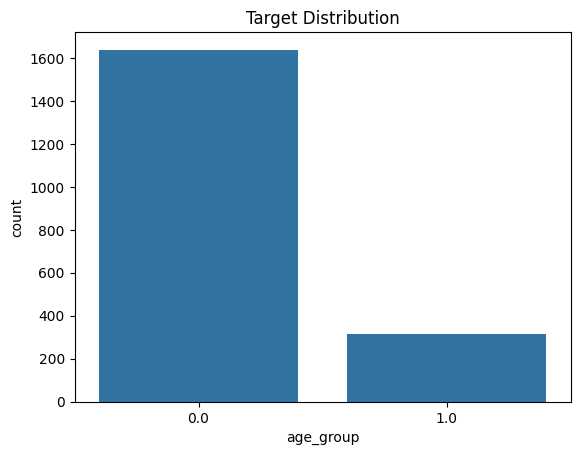

In [45]:
sns.countplot(x='age_group', data=train)
plt.title("Target Distribution")
plt.show()

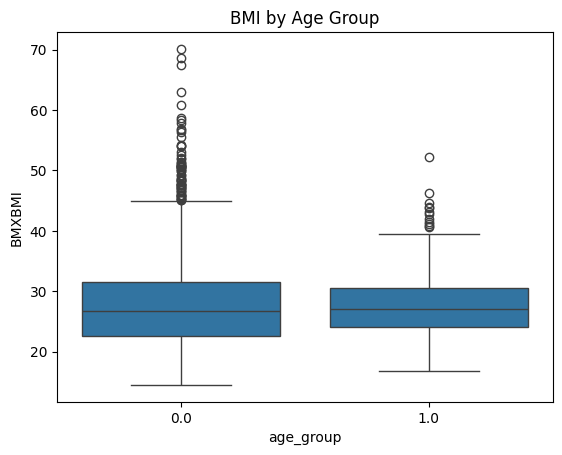

In [46]:
sns.boxplot(x='age_group', y='BMXBMI', data=train)
plt.title("BMI by Age Group")
plt.show()

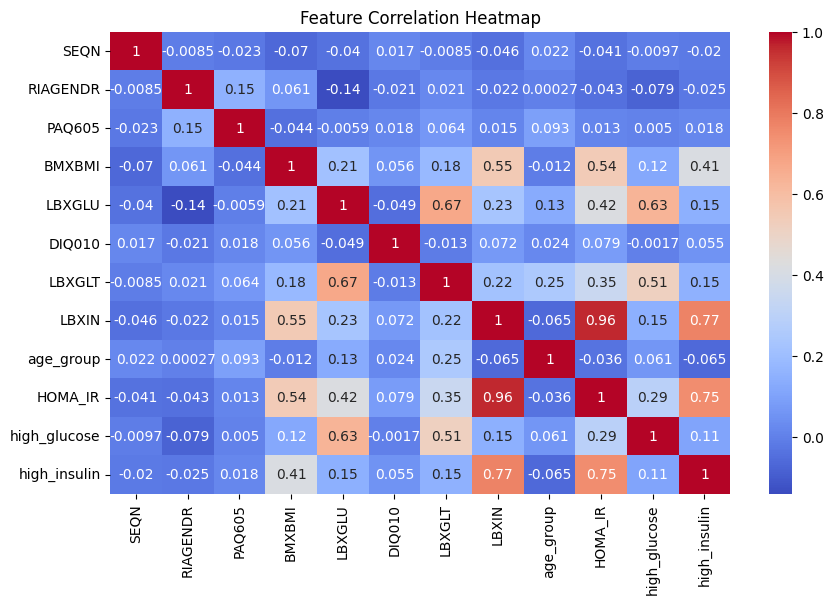

In [47]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [48]:
features = ['RIAGENDR', 'PAQ605', 'DIQ010', 'BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN',
            'HOMA_IR', 'high_glucose', 'high_insulin', 'BMI_cat']

X = train[features]
y = train['age_group']
X_test = test[features]

In [49]:
num_feats = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN', 'HOMA_IR']

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [50]:
cat_feats = ['RIAGENDR', 'PAQ605', 'DIQ010', 'BMI_cat']

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [51]:
bin_feats = ['high_glucose', 'high_insulin']

bin_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

In [52]:
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats),
    ('bin', bin_pipe, bin_feats)
])

In [53]:
# Modeling Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])

In [54]:
# Hyperparameter Grid
param_grid = {'classifier__C': [0.01, 0.1, 1, 10]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [55]:
mask = X.notnull().all(axis=1) & y.notnull()
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [56]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

In [57]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['BMXBMI',
                                                                          'LBXGLU',
                                                                          'LBXGLT',
                                                                          'LBXIN',
                                                                          'HOMA_IR']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['RIAGENDR',
                                                                          'PAQ605',
                                                                          'DIQ010',
                                                                          'BMI_cat']),
                                                                        ('bin',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['high_glucose',
                                                                          'high_insulin'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1, param_grid={'classifier__C': [0.01, 0.1, 1, 10]},
             scoring='f1', verbose=1)

In [58]:
y_val_pred = grid_search.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Validation Accuracy: 70.89%


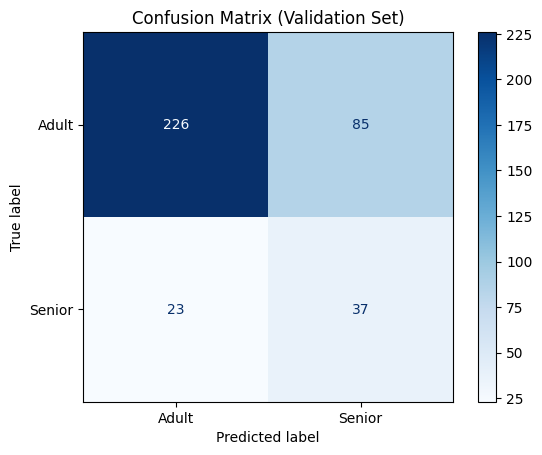

In [59]:
cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm, display_labels=['Adult', 'Senior']).plot(cmap='Blues')
plt.title("Confusion Matrix (Validation Set)")
plt.show()

In [60]:
print(classification_report(y_val, y_val_pred, target_names=['Adult', 'Senior']))

              precision    recall  f1-score   support

       Adult       0.91      0.73      0.81       311
      Senior       0.30      0.62      0.41        60

    accuracy                           0.71       371
   macro avg       0.61      0.67      0.61       371
weighted avg       0.81      0.71      0.74       371



In [61]:
y_val_proba = grid_search.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

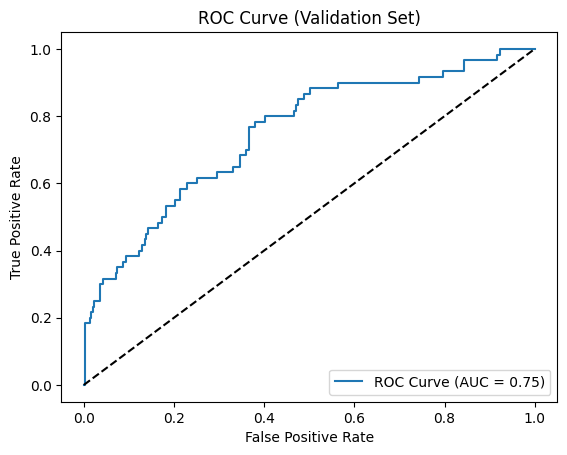

In [62]:
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend(loc="lower right")
plt.show()

In [63]:
train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X, y, cv=cv, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
)

In [64]:
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

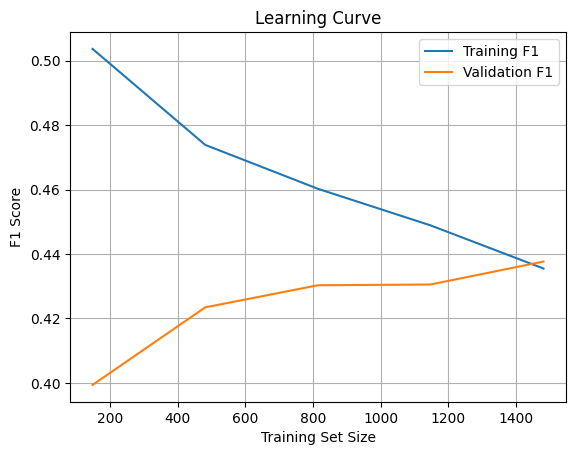

In [65]:
plt.figure()
plt.plot(train_sizes, train_mean, label="Training F1")
plt.plot(train_sizes, val_mean, label="Validation F1")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

In [66]:
X_test = X_test.reset_index(drop=True)
test_preds = grid_search.predict(X_test)
submission = pd.DataFrame({'age_group': test_preds.astype(int)})
submission.to_csv('submission.csv', index=False)

In [67]:
print("Submission file created: submission.csv")

Submission file created: submission.csv
